In [ ]:
# Sensor signal absence detection test
# Hans Verdolaga
# MSc Mechatronics 2023
# MC-F23 Thesis

In [37]:
# -----------------------------------------------------------------------------
# Libraries
# -----------------------------------------------------------------------------
# Import user libraries
import apriltag_config as cfg

# Import system libraries 
import os
import sys
import time
import ast

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
from scipy.signal import butter,filtfilt

%matplotlib inline

In [3]:
# -----------------------------------------------------------------------------
# High level information
# -----------------------------------------------------------------------------

warmupTime = 20 # seconds

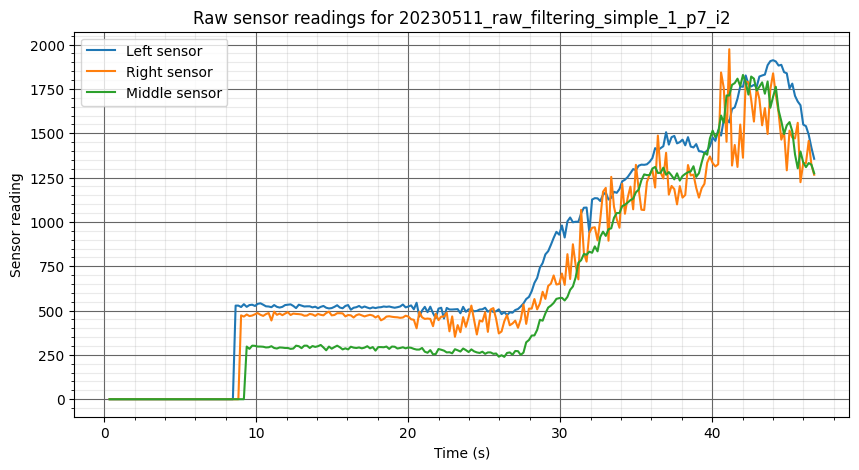

In [53]:
# -----------------------------------------------------------------------------
# Data loading
# -----------------------------------------------------------------------------
# Load data
runDate = '20230511'
runName = 'filtering_simple_1'
position = 7
iteration = 2
sensorLeft = '_sensorLeft'
sensorRight = '_sensorRight'
sensorMiddle = '_sensorMiddle'

osFolder = os.path.abspath("") + '/'
parentFolder = osFolder + 'robot_data/' + runDate + '_data/'

# Read raw sensor data CSV of a given run
sensorRawFolder = parentFolder + "raw_sensor_data/"
sensorRawFileNamePrefix = runDate + "_raw_" + runName + "_p" + str(position) + "_i" + str(iteration)
readingsLeft = pd.read_csv(sensorRawFolder + sensorRawFileNamePrefix + sensorLeft + ".csv")
readingsRight = pd.read_csv(sensorRawFolder + sensorRawFileNamePrefix + sensorRight + ".csv")
readingsMiddle = pd.read_csv(sensorRawFolder + sensorRawFileNamePrefix + sensorMiddle + ".csv")

# Plot readings
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['value'])
plt.plot(readingsRight['timeStamp'], readingsRight['value'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['value'])
plt.title(f'Raw sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor reading')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

In [39]:
# Butterworth filter
def butterLowPassFilter(filterCutOff, data, fs, order = 2):
    nyquist = 0.5 * fs
    normal_cutoff = filterCutOff / nyquist
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [69]:
def getDynamics(samples):
    # Select data for dynamics calculation
    original = np.copy(samples)

    # Copy and shift data array backwards by one step
    shifted = np.copy(original)
    shifted = np.delete(shifted, shifted.size-1)
    shifted = np.insert(shifted, 0, shifted[0])

    # Calculate the difference between the two arrays
    diff = np.subtract(original, shifted)
    incArr = np.greater(diff, 0) # Get increments
    decArr = np.less(diff, 0) # Get decrements

    # Calculate and return normalized increments and decrements
    return np.sum(incArr)/len(incArr), np.sum(decArr)/len(decArr)

In [90]:
filterCutOff = 0.1
fs = 1/(0.055*3)
samples = 20

# readingsLeft['filtered'] = butterLowPassFilter(filterCutOff, readingsLeft['value'], fs)
# readingsRight['filtered'] = butterLowPassFilter(filterCutOff, readingsRight['value'], fs)
# readingsMiddle['filtered'] = butterLowPassFilter(filterCutOff, readingsMiddle['value'], fs)

# Initialize new columns
readingsLeft['mean'] = readingsRight['mean'] = readingsMiddle['mean'] = 0
readingsLeft['variance'] = readingsRight['variance'] = readingsMiddle['variance'] = 0
readingsLeft['increment'] = readingsRight['increment'] = readingsMiddle['increment'] = 0
readingsLeft['decrement'] = readingsRight['decrement'] = readingsMiddle['decrement'] = 0

# Loop through each step 
for i in range(len(readingsLeft)):
    # Get previous 30 samples
    if i < samples:
        prevSamplesLeft = readingsLeft['value'].iloc[0:i]
        prevSamplesRight = readingsRight['value'].iloc[0:i]
        prevSamplesMiddle = readingsMiddle['value'].iloc[0:i]
    else:
        prevSamplesLeft = readingsLeft['value'].iloc[i-samples:i]
        prevSamplesRight = readingsRight['value'].iloc[i-samples:i]
        prevSamplesMiddle = readingsMiddle['value'].iloc[i-samples:i]

        # Filter for samples above 50 count
        prevSamplesLeft = butterLowPassFilter(filterCutOff, prevSamplesLeft, fs)
        prevSamplesRight = butterLowPassFilter(filterCutOff, prevSamplesRight, fs)
        prevSamplesMiddle = butterLowPassFilter(filterCutOff, prevSamplesMiddle, fs)

    # Calculate mean, variance, increment and decrement
    meanLeft = np.mean(prevSamplesLeft)
    meanRight = np.mean(prevSamplesRight)
    meanMiddle = np.mean(prevSamplesMiddle)

    varLeft = np.var(prevSamplesLeft)
    varRight = np.var(prevSamplesRight)
    varMiddle = np.var(prevSamplesMiddle)

    if i > 1:
        incLeft, decLeft = getDynamics(prevSamplesLeft)
        incRight, decRight = getDynamics(prevSamplesRight)
        incMiddle, decMiddle = getDynamics(prevSamplesMiddle)
    else:
        incLeft, decLeft = incRight, decRight = incMiddle, decMiddle = 0, 0

    # Write to new columns
    readingsLeft['mean'].iloc[i] = meanLeft
    readingsLeft['variance'].iloc[i] = varLeft
    readingsLeft['increment'].iloc[i] = incLeft
    readingsLeft['decrement'].iloc[i] = decLeft

    readingsRight['mean'].iloc[i] = meanRight
    readingsRight['variance'].iloc[i] = varRight
    readingsRight['increment'].iloc[i] = incRight
    readingsRight['decrement'].iloc[i] = decRight

    readingsMiddle['mean'].iloc[i] = meanMiddle
    readingsMiddle['variance'].iloc[i] = varMiddle
    readingsMiddle['increment'].iloc[i] = incMiddle
    readingsMiddle['decrement'].iloc[i] = decMiddle

C:\Users\hansv\AppData\Local\Temp\ipykernel_14480\4266134426.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readingsLeft['mean'].iloc[i] = meanLeft
C:\Users\hansv\AppData\Local\Temp\ipykernel_14480\4266134426.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readingsLeft['variance'].iloc[i] = varLeft
C:\Users\hansv\AppData\Local\Temp\ipykernel_14480\4266134426.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readingsLeft['

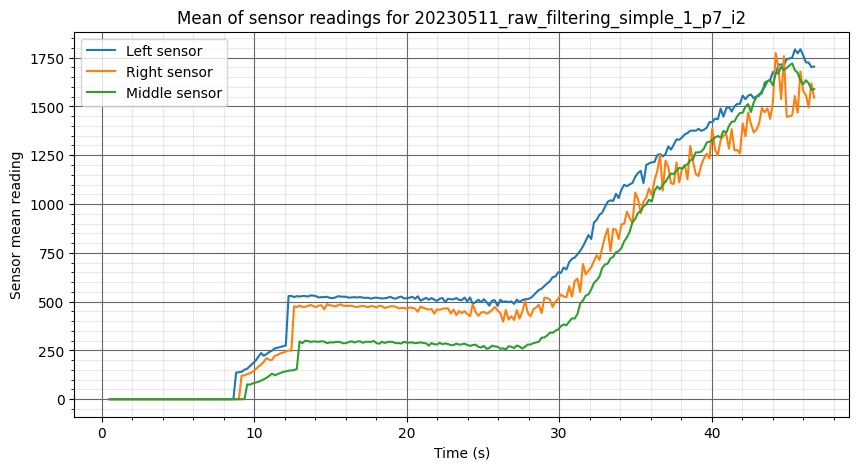

In [91]:
# Plot means
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['mean'])
plt.plot(readingsRight['timeStamp'], readingsRight['mean'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['mean'])
plt.title(f'Mean of sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor mean reading')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

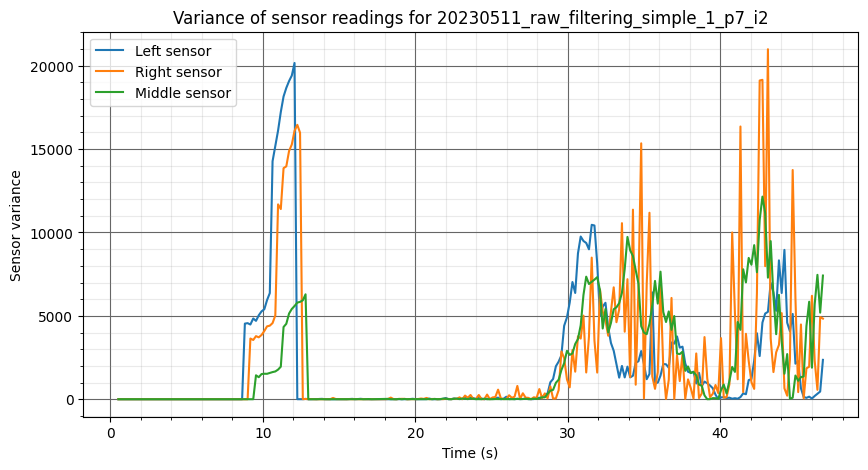

In [92]:
# Plot variances
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['variance'])
plt.plot(readingsRight['timeStamp'], readingsRight['variance'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['variance'])
plt.title(f'Variance of sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor variance')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

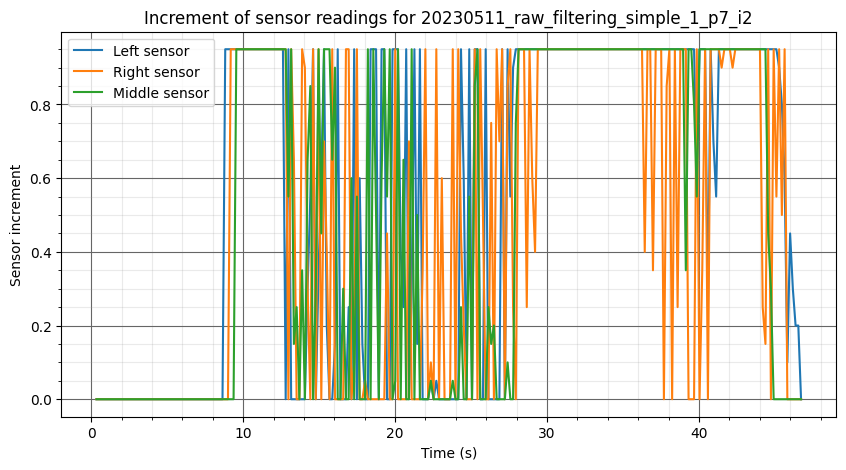

In [93]:
# Plot increments
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['increment'])
plt.plot(readingsRight['timeStamp'], readingsRight['increment'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['increment'])
plt.title(f'Increment of sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor increment')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

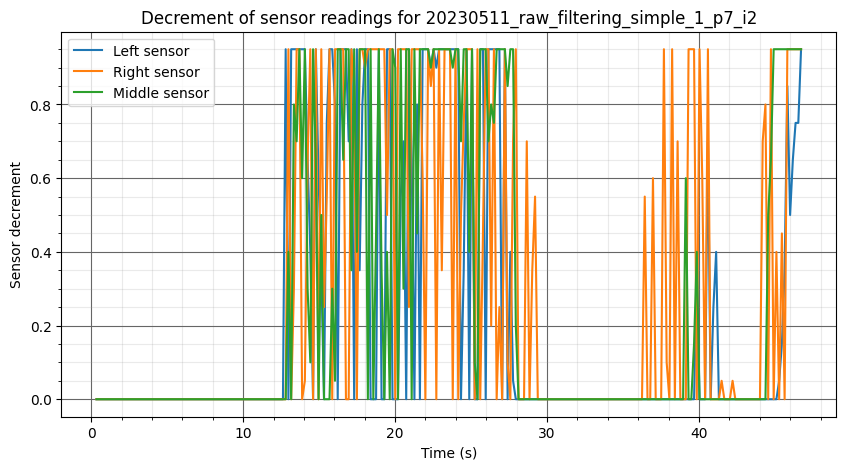

In [94]:
# Plot decrements
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['decrement'])
plt.plot(readingsRight['timeStamp'], readingsRight['decrement'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['decrement'])
plt.title(f'Decrement of sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor decrement')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()

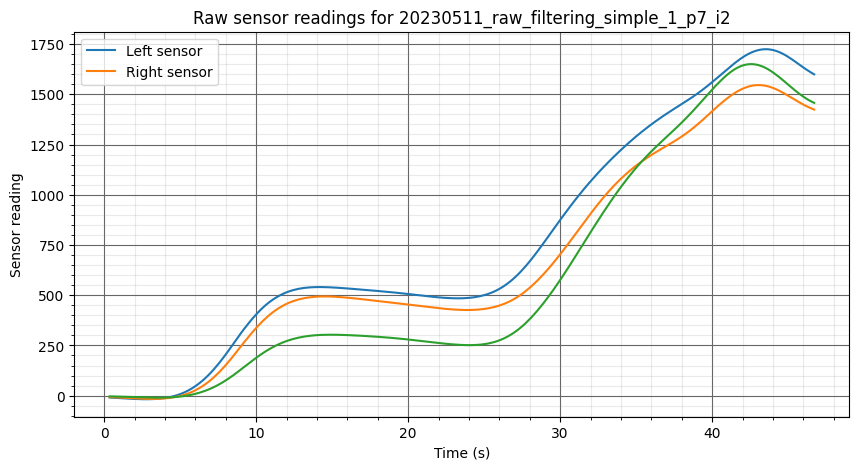

In [51]:
# Plot readings
plt.figure(figsize=(10,5))
plt.plot(readingsLeft['timeStamp'], readingsLeft['filtered'])
plt.plot(readingsRight['timeStamp'], readingsRight['filtered'])
plt.plot(readingsMiddle['timeStamp'], readingsMiddle['filtered'])
plt.title(f'Raw sensor readings for {sensorRawFileNamePrefix}')
plt.xlabel('Time (s)')
plt.ylabel('Sensor reading')
plt.legend(['Left sensor', 'Right sensor', 'Middle sensor'])

# Draw vertical grid lines with 1 unit separation
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()